# Simple Linear Regression

In [1]:
Boyle.activate("project-numy")

Resolving Hex dependencies...
Dependency resolution completed:
Unchanged:
  gnuplot 1.19.96
  numy 0.1.5
All dependencies are up to date
make: Nothing to be done for 'all'.


:ok

## Linear Regression

Say we have a set of points with coordinates {x,y}.
In case these point correspond to some linear process,
it should be possible to figure our the slope and interception
of the linear model from the data points.

> In linear regression, the relationships are modeled using
> linear predictor functions whose unknown model parameters
> are estimated from the data.

  We want to find a linear model α + βx, that for each x gives a value
  that is close to y from the data set.
  One approach to estimating the unknowns α and β is
  to consider the sum of squared residuals function, or SSR.

  >
  > ∑rᵢ² = ∑(yᵢ - α - βxᵢ)²
  >

  It is a fact that among all possible α and β, the following
  values minimize the SSR:

  > 1. β = cov(x,y) / var(x)
  > 2. α = ȳ - βx̄
  >
  
  That is, from practical point of view, all we need is to calculate
  covariance and variance.

## Numy.Fit.SimpleLinear

Basic vector operations like `mean`, `offset`, `pow2` and `sum` provide
enough functions to implement simple and stable two-pass algorithms to
calculate *variance* and *covariance*. With these two values we get a slope
of fitting line; then, geting interception is trivial. 

Elixir module `Numy.Fit.SimpleLinear` does just that. It uses `Vc` and `Vcm` protocols to call vector functions to calculate the slope and interception of a line that fits input data. Let us see how it works.

We start with constructing an input dataset. First, we create points
on a line with slope 2 and intercept -3.
Then we randomly move the points in order to introduce some noise to the data.

In [2]:
alias Numy.{Vc,Vcm}
alias Numy.Lapack.Vector, as: Lv

Numy.Lapack.Vector

In [3]:
xs = Lv.new(0..9) # x points, from 0 to 9

#Vector<size=10, [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]>

In [10]:
# y points: take x points, scale them by 2 and then move down by 3
ys_ideal = xs |> Vc.scale(2) |> Vcm.offset!(-3)

#Vector<size=10, [-3.0, -1.0, 1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0]>

Next, we generate a vector of small random numbers.

In [23]:
err = Lv.new(10) |> Vc.assign_random

#Vector<size=10, [0.664255510615694, 0.5882049267307631, 0.9445944249221905, 0.8354412971219026, 0.4244430558496487, 0.45008170049853946, 0.6387496810528502, 0.9956223851992372, 0.9712671713885004, 0.402398374019303]>

The random numbers are in the range `[0..1]`. Let us shift them all down by 0.5
to make new range `[-0.5..0.5]`.

In [24]:
err |> Vcm.offset!(-0.5)

#Vector<size=10, [0.164255510615694, 0.08820492673076308, 0.4445944249221905, 0.3354412971219026, -0.0755569441503513, -0.04991829950146054, 0.13874968105285024, 0.4956223851992372, 0.4712671713885004, -0.097601625980697]>

Now we can add vector of errors to the ys vector and get the dataset that we are going to use to demonstrate how `Fit.SimpleLinear` works.

In [25]:
ys = Vc.add(ys_ideal,err)

#Vector<size=10, [-2.835744489384306, -0.9117950732692369, 1.4445944249221905, 3.3354412971219025, 4.924443055849649, 6.950081700498539, 9.13874968105285, 11.495622385199237, 13.4712671713885, 14.902398374019302]>

The input dataset is ready and is made of 2 vectors: xs and ys.
We are going to call function `Fit.SimpleLinear.fit` that returns
a tuple with an interception and slope.

In [26]:
line = Numy.Fit.SimpleLinear.fit(xs, ys)

{-2.8089148312891448, 2.0000934853397796}

As you can see, we get the fitting line that has the intercept close to -3
and the slope close to 2, as expected. Thus, we have demonstrated that
the algorithm works.

Now we can check what this model predicts for each point x.

In [29]:
predicted = for x <- Vc.data(xs), do: Numy.Fit.SimpleLinear.predict(x, line)

[-2.8089148312891448, -0.8088213459493652, 1.1912721393904144, 3.191365624730194, 5.191459110069974, 7.191552595409752, 9.191646080749532, 11.191739566089314, 13.191833051429093, 15.191926536768872]

Next, we can plot 3 datasets:

1. Original ideal line
2. Data points that we get from the ideal line by adding some random values.
3. Predicted values.

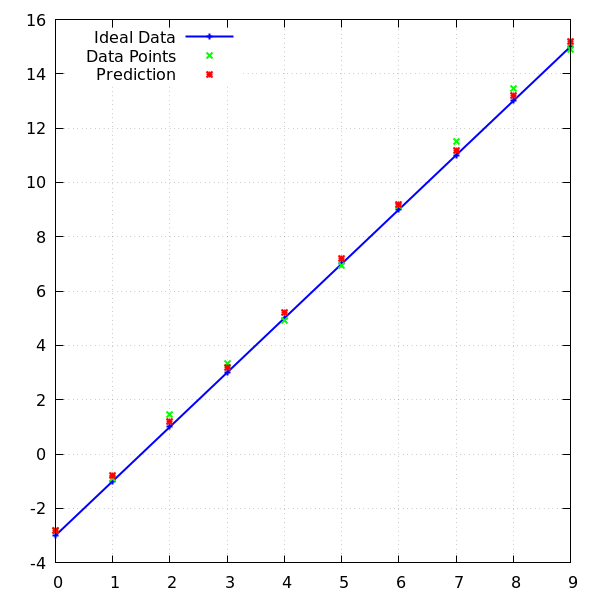

In [36]:
datasets = for ds <- [Vc.data(ys_ideal),Vc.data(ys),predicted], do:
  Enum.zip(Vc.data(xs), ds)

Gnuplot.plot([
  ~w(set terminal pngcairo size 600,600)a,
  ~w(set output)a,
  ~w(set key left top)a,
  ~w(set grid xtics ytics)a,
  ~w(set style line 1 lw 2 lc 'blue')a,
  ~w(set style line 2 lw 2 lc 'green')a,
  ~w(set style line 3 lw 2 lc 'red')a,
  Gnuplot.plots([
    ["-", :title, "Ideal Data", :with, :linespoints, :ls, 1],
    ["-", :title, "Data Points", :with, :points, :ls, 2],
    ["-", :title, "Prediction", :with, :points, :ls, 3]
  ])
  ],
  datasets
)

Numy.Gnuplot.capture() |> Base.encode64 |> IO.write
:"this is an inline image"

## Pearson correlation coefficient

  Pearson's correlation coefficient is the covariance of the two variables
  divided by the product of their standard deviations.

  A value of 1 implies that a linear equation describes the relationship
  between X and Y perfectly, with all data points lying on a line
  for which Y increases as X increases.
  A value of 0 implies that there is no linear correlation between the variables.

In [35]:
Numy.Fit.SimpleLinear.pearson_correlation(ys, Lv.new(predicted))

0.9992691855457837